In [1]:
import os
import warnings

import gymnasium as gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PlotRenderer
from gym_trading.envs.rewards import ProfitRewarder, OneStepProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_top_ranked_cryptos(n):
    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={n}&page=1&sparkline=false"

    response = requests.get(url)
    data = response.json()

    top_cryptos = []
    for crypto in data:
        # print(crypto)
        top_cryptos.append(crypto['id'])

    return top_cryptos

In [3]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

In [4]:
N_DAYS = 360 * 3
SAVE_DIR = "crypto_datasets__days-" + str(N_DAYS)

In [5]:
def save_datasets(datasets, days):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    for symbol, df in datasets.items():
        filename = f"{symbol}_{days}_days.csv"
        file_path = os.path.join(SAVE_DIR, filename)
        df.to_csv(file_path, index=False)
        print(f"Saved {symbol} dataset to {file_path}")
        
def load_datasets():
    datasets = {}
    try:
        for file in os.listdir(SAVE_DIR):
            if file.endswith(".csv"):
                symbol, days, _ = file.split("_")
                days = int(days)
                file_path = os.path.join(SAVE_DIR, file)
                df = pd.read_csv(file_path)
                datasets[symbol] = df
    except FileNotFoundError:
        return datasets
    return datasets

In [6]:
datasets = load_datasets()

if len(datasets.keys()) == 0:
    print('downloading new data')
    
    top_cryptos = get_top_ranked_cryptos(10)
    print('Downloading datasets for top cryptos: {top_cryptos}')
    
    df = pd.DataFrame()

    for symbol in top_cryptos:
        df = get_symbol_history(symbol, N_DAYS)

        # removing the last row since someimes are not aligned
        df.drop(df.index[-1], inplace=True)

        datasets[symbol] = df
        
    save_datasets(datasets, N_DAYS)

In [7]:
for symbol, df in datasets.items():
    df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Removing stable coins and crypto with less days than expected
del datasets['staked-ether']
del datasets['tether']
del datasets['usd-coin']

In [9]:
df = list(datasets.values())[0]
df['Date'].iloc[1] - df['Date'].iloc[0]

Timedelta('1 days 00:00:00')

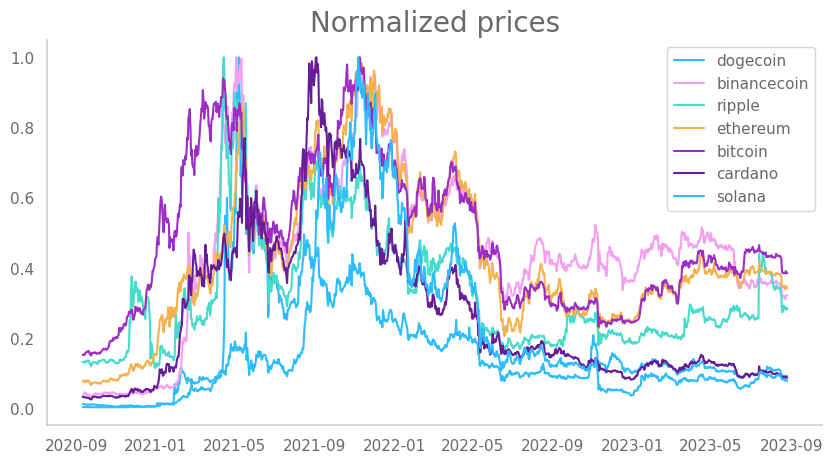

In [10]:
for symbol, df in datasets.items():
    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)

plt.title('Normalized prices')
plt.legend()
plt.show()

In [11]:
SYMBOLS = list(datasets.keys())
SYMBOLS

['dogecoin',
 'binancecoin',
 'ripple',
 'ethereum',
 'bitcoin',
 'cardano',
 'solana']

In [12]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    return train_df, valid_df, test_df

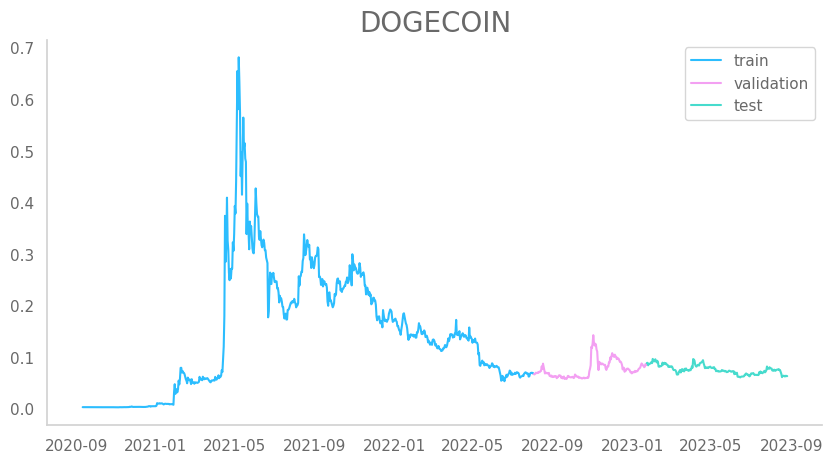

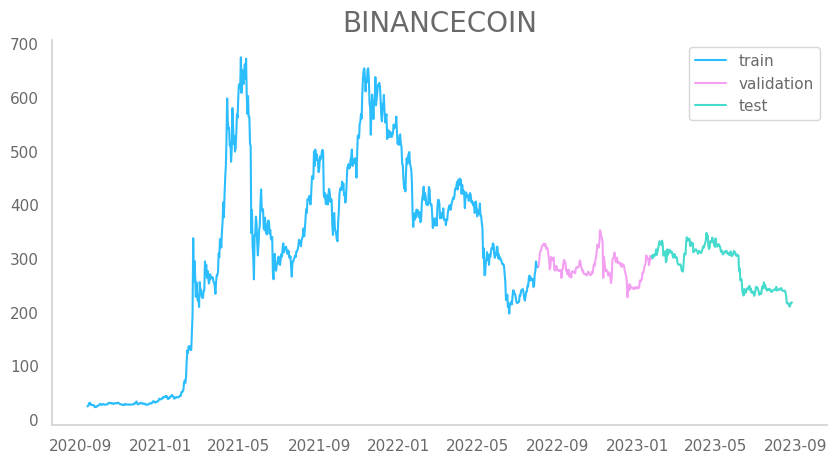

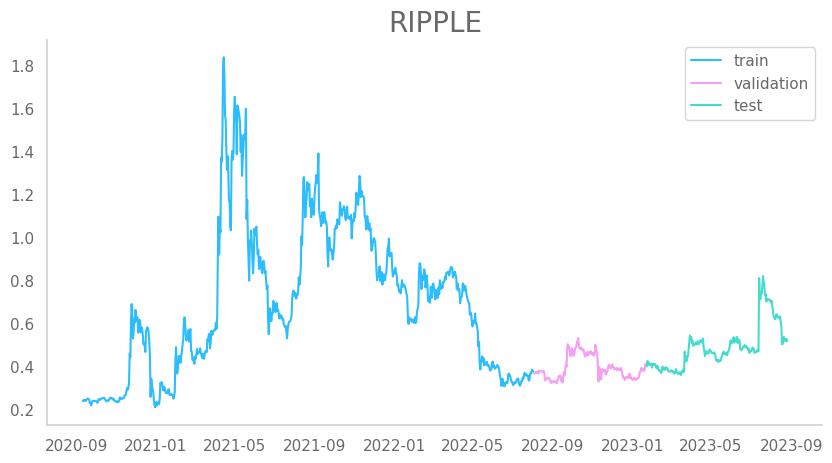

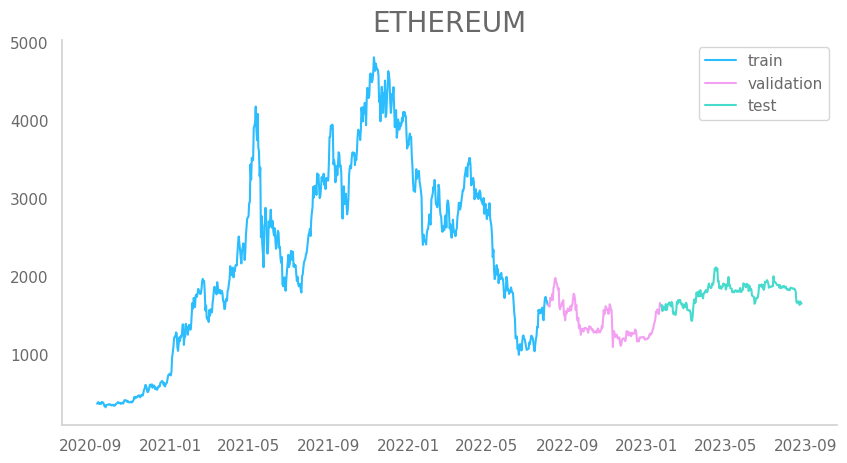

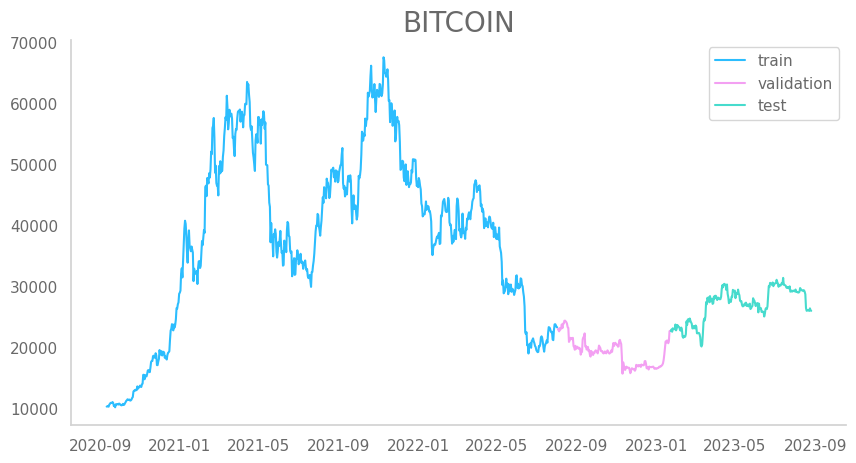

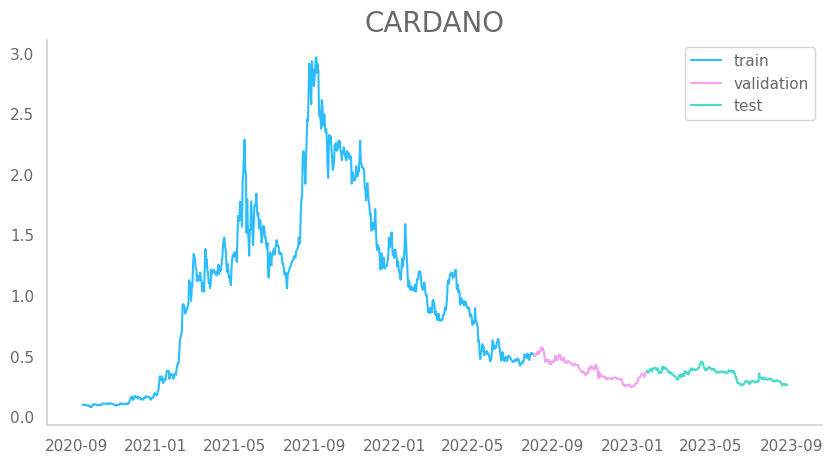

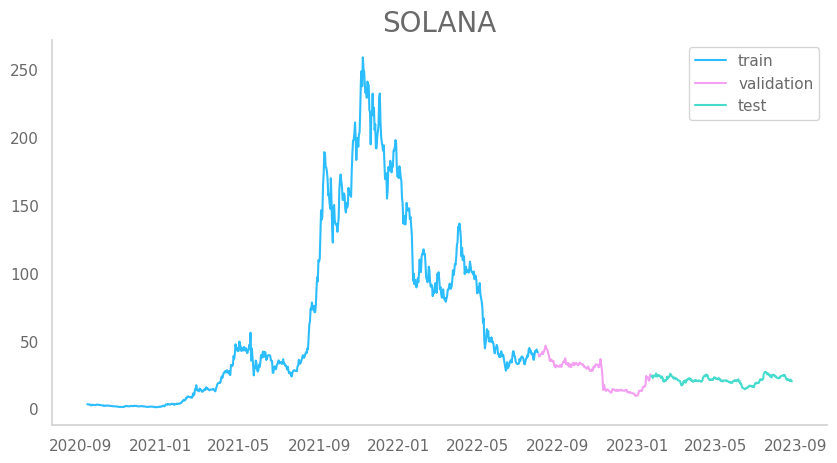

In [13]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

In [14]:
INIT_LIQUIDITY = 100.0
BUY_FEE = 0.1
SELL_FEE = 0.1

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PlotRenderer(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PlotRenderer(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PlotRenderer(),
)

In [15]:
observation = train_env.reset()[0]
observation

array([[2.8127306e-03, 3.5497917e+08, 1.6348867e+08, 2.4413843e+01,
        3.6037043e+09, 4.8086429e+08, 2.4300109e-01, 1.0937780e+10,
        1.7077228e+09, 3.6763892e+02, 4.1300328e+10, 7.4747421e+10,
        1.0342159e+04, 1.9118057e+11, 7.7545791e+10, 9.7060449e-02,
        3.0172767e+09, 6.7357299e+08, 3.4530900e+00, 1.1875915e+08,
        3.1817980e+07]], dtype=float32)

In [16]:
observation.shape

(1, 21)

In [17]:
class Agent(ABC):

    @abstractmethod
    def action(self, observation: np.ndarray) -> np.ndarray:
        pass

In [18]:
def simulate(agent: Agent, env, render=False):
    print('Simulating a trading session with agent:', agent.__class__.__name__)
    observation, _ = env.reset()
    
    done = False
    while not done:
        action = agent.action(observation)
        observation, reward, done, _, _ = env.step(action)
        
    if render:
        env.render()
        
    return reward

In [19]:
class RandomAgent(Agent):
    
    def action(self, observation: np.ndarray) -> np.ndarray:
        return BudgetAllocationSpace(len(SYMBOLS)).sample()
    
class UniformAgent(Agent):

    def action(self, observation: np.ndarray) -> np.ndarray:
        return np.ones(len(SYMBOLS)) / len(split_datasets.keys())

Simulating a trading session with agent: RandomAgent


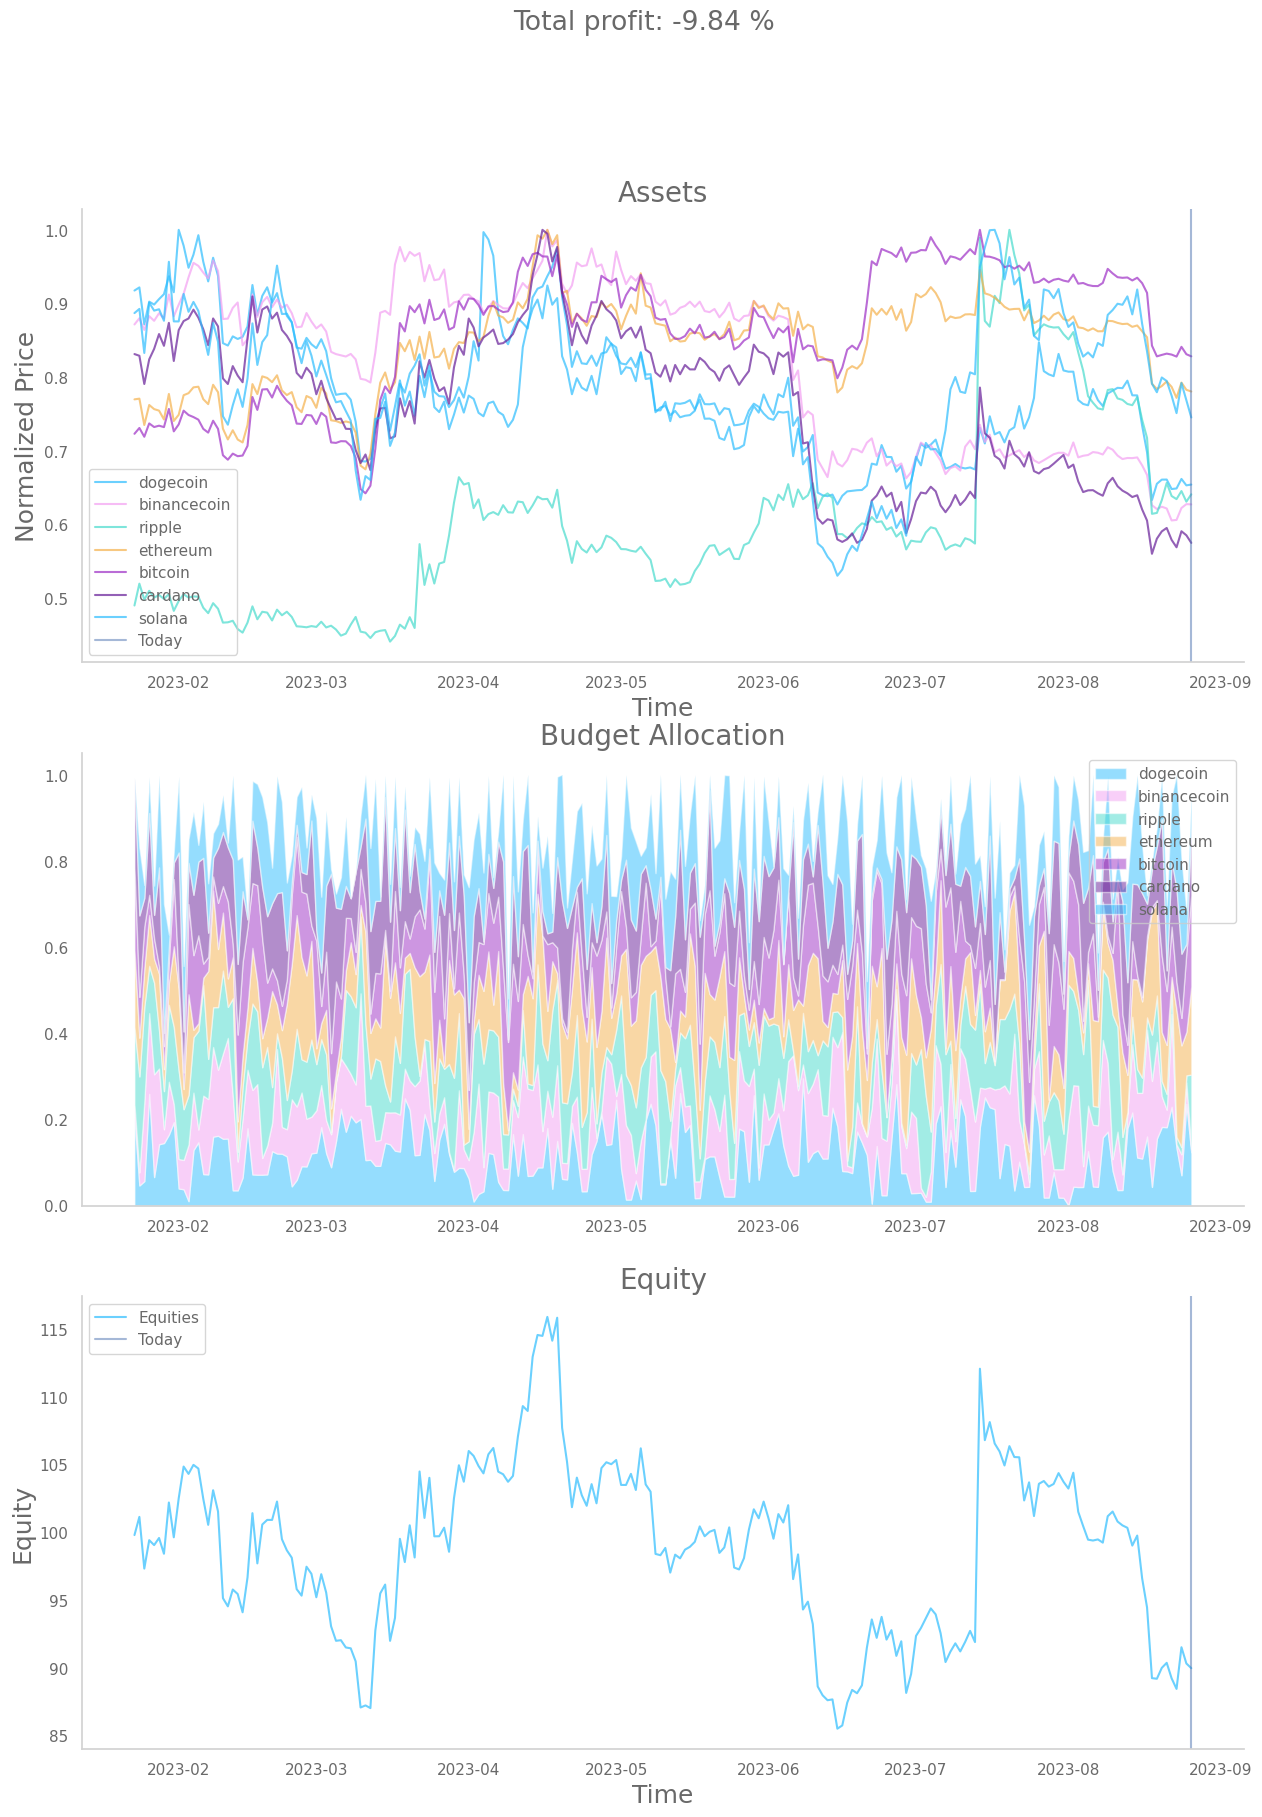

-0.3845626044934547

In [20]:
simulate(RandomAgent(), test_env, render=True)

Simulating a trading session with agent: UniformAgent


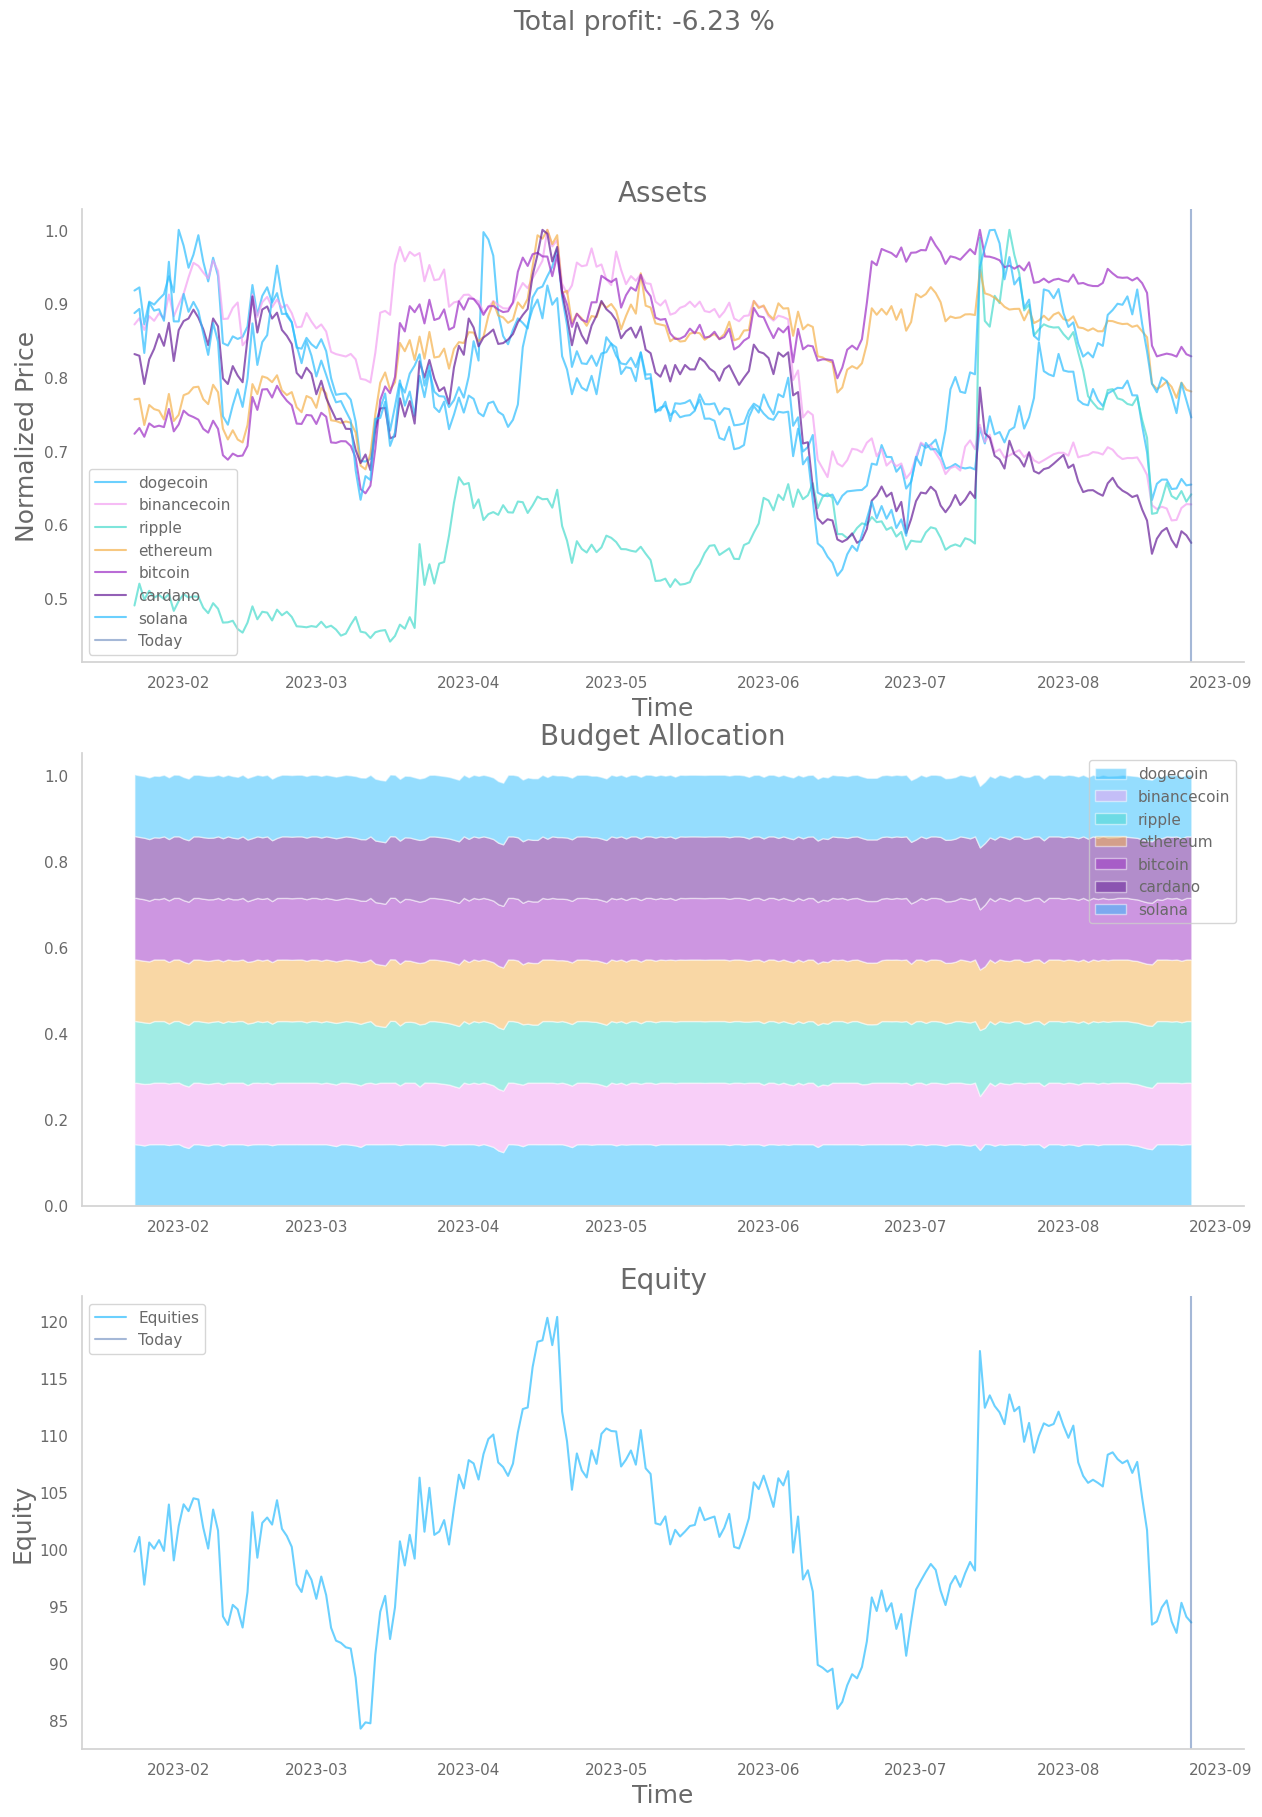

-0.533946947537467

In [21]:
simulate(UniformAgent(), test_env, render=True)

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Preprocessor():
    
    def __init__(self, window_size=2):
        self.ws = window_size
        self.buffer = []

    def preprocess(self, observation):
        self.buffer.append(observation)
        
        if len(self.buffer) > self.ws:
            self.buffer.pop(0)
        
        while len(self.buffer) < self.ws:
            self.buffer.insert(0, np.zeros_like(observation))
        
        stacked_data = np.vstack(self.buffer)
        return StandardScaler().fit_transform(stacked_data)

In [23]:
processor = Preprocessor()
processor.preprocess(observation).shape

(2, 21)

In [24]:
from typing import List, Any, Tuple, SupportsFloat
from gymnasium.experimental.functional import ObsType
from gymnasium.core import ActType
from gymnasium.spaces import Box

class GymWrapper(gym.Env):
    
    def __init__(self, env):
        super(GymWrapper, self).__init__()
        
        self.processor = Preprocessor()
        
        self.env = env
        self.action_space = env.action_space
        self.observation_space = Box(
            low=-np.inf, 
            high=np.inf, 
            shape=self.processor.preprocess(np.zeros(self.env.observation_space.shape)).shape
        )
        
        self.last_reward = 0

    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict[str, Any] | None = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        observation, info = self.env.reset()
        self.processor = Preprocessor()
        self.last_reward = 0

        return self.processor.preprocess(observation), info

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        observation, reward, done, truncated, info = self.env.step(action)
        observation = self.processor.preprocess(observation)
        return observation, reward, done, truncated, info

In [25]:
class SB3Agent(Agent):
    
    def __init__(self, model):
        self.model = model
        
        self.processor = Preprocessor()

    def action(self, observation: np.ndarray) -> np.ndarray:
        observation = self.processor.preprocess(observation)
        action = self.model.predict(observation, deterministic=True)[0]
        return action

In [26]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, StackedObservations

# Creating and wrapping the environments
train_vec_env = SubprocVecEnv([lambda: GymWrapper(train_env)] * 8)
# train_vec_env = DummyVecEnv([lambda: GymWrapper(train_env)])
valid_vec_env = DummyVecEnv([lambda: GymWrapper(valid_env)])
test_vec_env = DummyVecEnv([lambda: GymWrapper(test_env)])

In [27]:
# def evaluate(model, vec_env):
# #     mean_reward, std_reward = evaluate_policy(
# #         model, 
# #         vec_env, 
# #         n_eval_episodes=1,
# #         deterministic=True,
# #         render=False
# #     )
#     for env in vec_env.envs:
#         simulate(model, env, render=True)
#         env.render()
# #     print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [28]:
df_train = list(split_datasets.values())[0][0]
n_train_timestamps = df_train.count()['Date']
n_train_timestamps

691

In [29]:
log_dir = './logs/'
time_steps = n_train_timestamps ** 2
time_steps

477481

In [30]:
model = PPO(
    policy="MlpPolicy",
    env=train_vec_env,
    verbose=1,
    tensorboard_log=log_dir,
)

Using cuda device


Evaluate on test env before training
Simulating a trading session with agent: SB3Agent


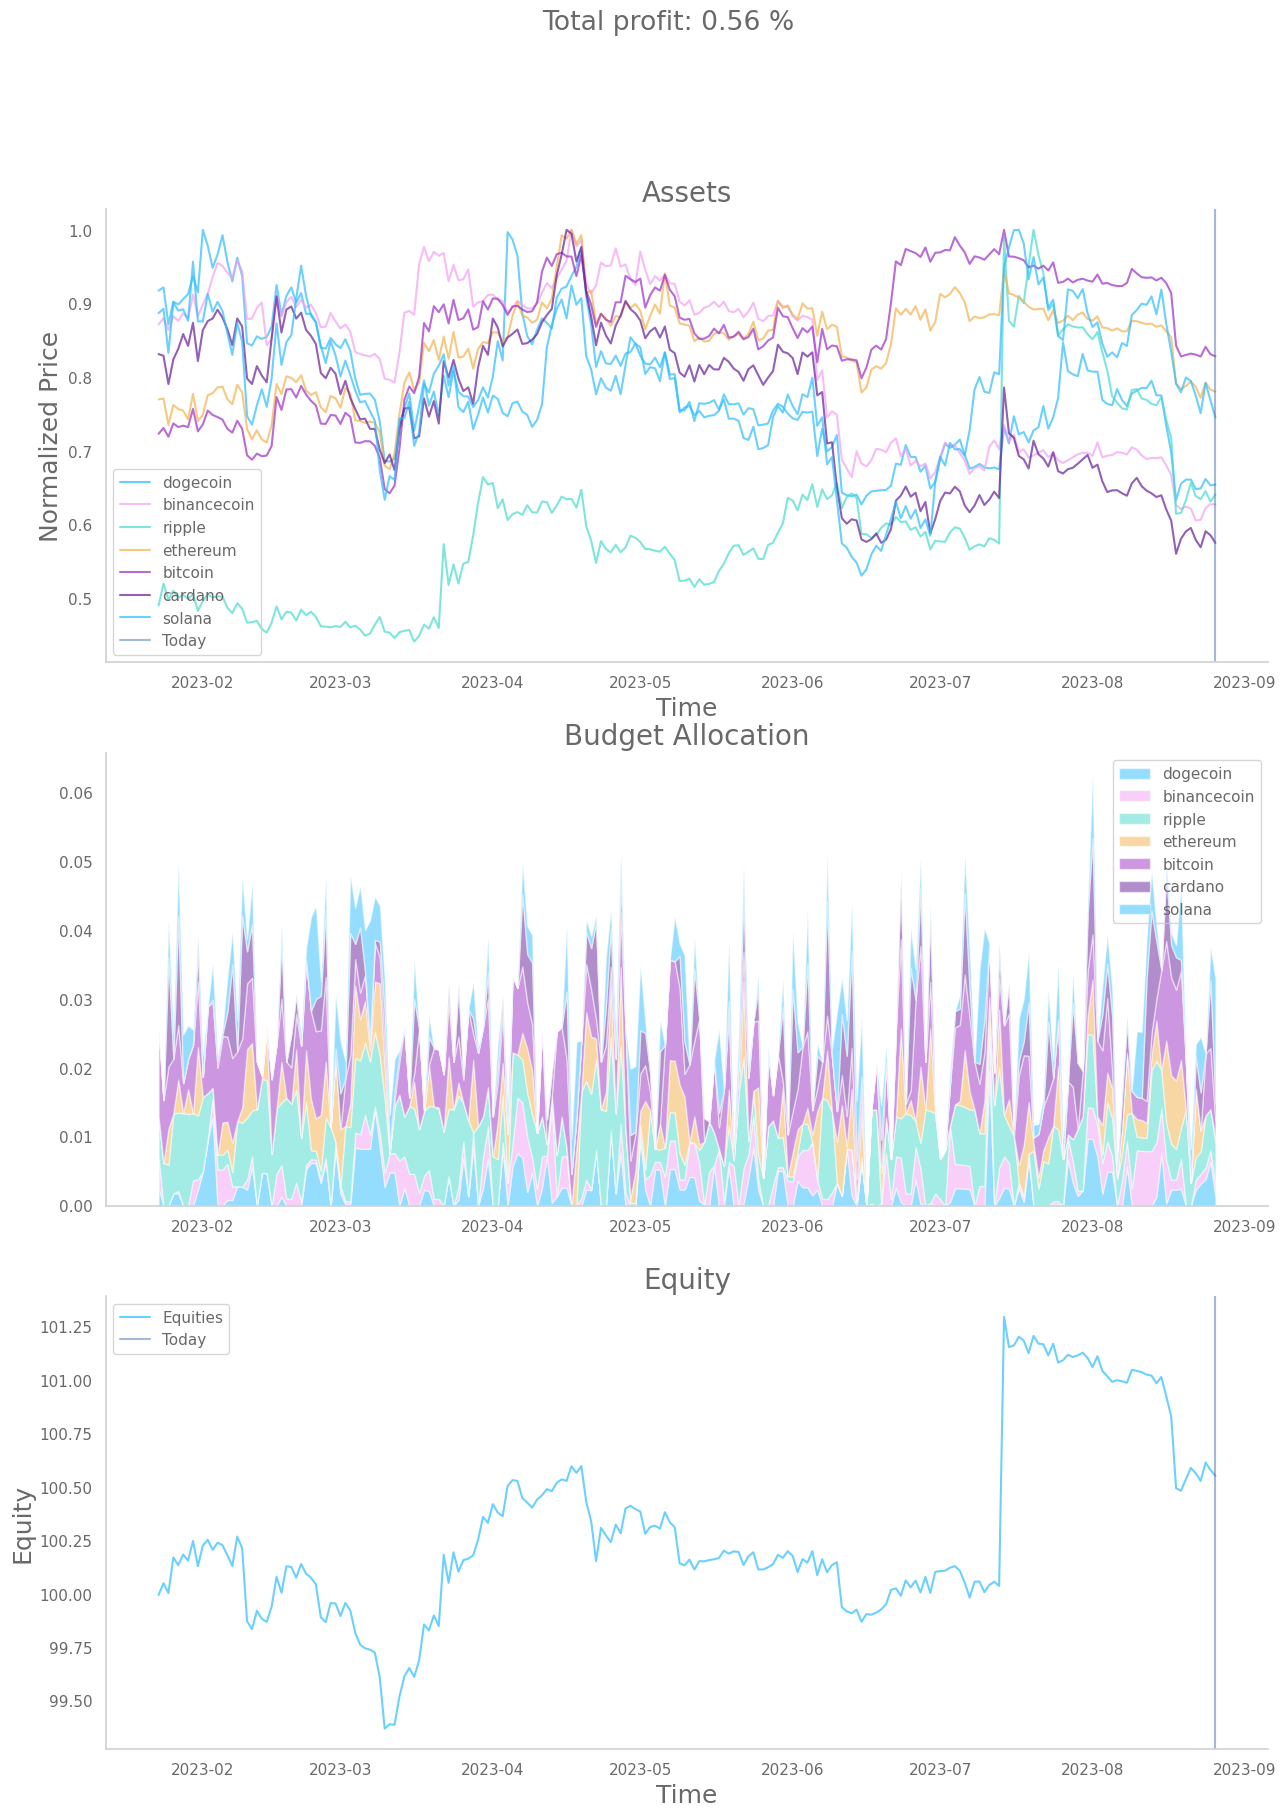

-0.027423398942494348

In [31]:
print('Evaluate on test env before training')
simulate(SB3Agent(model), test_env, render=True)

In [32]:
eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=int(time_steps),
    callback=callbacks,
    progress_bar=True
)

Logging to ./logs/PPO_3


Output()

Eval num_timesteps=8000, episode_reward=0.28 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0.28     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------


New best mean reward!

Eval num_timesteps=16000, episode_reward=0.28 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0.28     |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 213   |
|    iterations      | 1     |
|    time_elapsed    | 76    |
|    total_timesteps | 16384 |
------------------------------


Eval num_timesteps=24000, episode_reward=5.75 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 5.75         |
| time/                   |              |
|    total_timesteps      | 24000        |
| train/                  |              |
|    approx_kl            | 0.0071039894 |
|    clip_fraction        | 0.074        |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.91        |
|    explained_variance   | -0.000916    |
|    learning_rate        | 0.0003       |
|    loss                 | 404          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00539     |
|    std                  | 0.997        |
|    value_loss           | 293          |
------------------------------------------


New best mean reward!

Eval num_timesteps=32000, episode_reward=5.75 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 5.75     |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 202   |
|    iterations      | 2     |
|    time_elapsed    | 161   |
|    total_timesteps | 32768 |
------------------------------


Eval num_timesteps=40000, episode_reward=-0.22 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.007571505 |
|    clip_fraction        | 0.0728      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.91       |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 64          |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00698    |
|    std                  | 0.995       |
|    value_loss           | 228         |
-----------------------------------------


Eval num_timesteps=48000, episode_reward=-0.22 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -0.215   |
| time/              |          |
|    total_timesteps | 48000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 199   |
|    iterations      | 3     |
|    time_elapsed    | 245   |
|    total_timesteps | 49152 |
------------------------------


Eval num_timesteps=56000, episode_reward=-2.56 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -2.56       |
| time/                   |             |
|    total_timesteps      | 56000       |
| train/                  |             |
|    approx_kl            | 0.007052978 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.87       |
|    explained_variance   | 0.438       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00635    |
|    std                  | 0.991       |
|    value_loss           | 195         |
-----------------------------------------


Eval num_timesteps=64000, episode_reward=-2.56 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -2.56    |
| time/              |          |
|    total_timesteps | 64000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 197   |
|    iterations      | 4     |
|    time_elapsed    | 332   |
|    total_timesteps | 65536 |
------------------------------


Eval num_timesteps=72000, episode_reward=0.17 +/- 0.00

Episode length: 173.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 173        |
|    mean_reward          | 0.167      |
| time/                   |            |
|    total_timesteps      | 72000      |
| train/                  |            |
|    approx_kl            | 0.00774654 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.88      |
|    explained_variance   | 0.502      |
|    learning_rate        | 0.0003     |
|    loss                 | 64.3       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.00571   |
|    std                  | 0.992      |
|    value_loss           | 278        |
----------------------------------------


Eval num_timesteps=80000, episode_reward=0.17 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0.167    |
| time/              |          |
|    total_timesteps | 80000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 194   |
|    iterations      | 5     |
|    time_elapsed    | 420   |
|    total_timesteps | 81920 |
------------------------------


Eval num_timesteps=88000, episode_reward=6.57 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 6.57         |
| time/                   |              |
|    total_timesteps      | 88000        |
| train/                  |              |
|    approx_kl            | 0.0077979127 |
|    clip_fraction        | 0.0895       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.85        |
|    explained_variance   | 0.605        |
|    learning_rate        | 0.0003       |
|    loss                 | 87.3         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00659     |
|    std                  | 0.988        |
|    value_loss           | 270          |
------------------------------------------


New best mean reward!

Eval num_timesteps=96000, episode_reward=6.57 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 6.57     |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 194   |
|    iterations      | 6     |
|    time_elapsed    | 506   |
|    total_timesteps | 98304 |
------------------------------


Eval num_timesteps=104000, episode_reward=-0.97 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | -0.97        |
| time/                   |              |
|    total_timesteps      | 104000       |
| train/                  |              |
|    approx_kl            | 0.0071531786 |
|    clip_fraction        | 0.0782       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.86        |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.0003       |
|    loss                 | 291          |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00484     |
|    std                  | 0.988        |
|    value_loss           | 299          |
------------------------------------------


Eval num_timesteps=112000, episode_reward=-0.97 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -0.97    |
| time/              |          |
|    total_timesteps | 112000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 193    |
|    iterations      | 7      |
|    time_elapsed    | 592    |
|    total_timesteps | 114688 |
-------------------------------


Eval num_timesteps=120000, episode_reward=-0.56 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -0.556      |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.009105597 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.81       |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.0003      |
|    loss                 | 160         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00697    |
|    std                  | 0.981       |
|    value_loss           | 426         |
-----------------------------------------


Eval num_timesteps=128000, episode_reward=-0.56 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -0.556   |
| time/              |          |
|    total_timesteps | 128000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 193    |
|    iterations      | 8      |
|    time_elapsed    | 678    |
|    total_timesteps | 131072 |
-------------------------------


Eval num_timesteps=136000, episode_reward=-2.43 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -2.43       |
| time/                   |             |
|    total_timesteps      | 136000      |
| train/                  |             |
|    approx_kl            | 0.008628979 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.79       |
|    explained_variance   | 0.71        |
|    learning_rate        | 0.0003      |
|    loss                 | 117         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00565    |
|    std                  | 0.979       |
|    value_loss           | 279         |
-----------------------------------------


Eval num_timesteps=144000, episode_reward=-2.43 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -2.43    |
| time/              |          |
|    total_timesteps | 144000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 193    |
|    iterations      | 9      |
|    time_elapsed    | 763    |
|    total_timesteps | 147456 |
-------------------------------


Eval num_timesteps=152000, episode_reward=-10.59 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -10.6       |
| time/                   |             |
|    total_timesteps      | 152000      |
| train/                  |             |
|    approx_kl            | 0.008528886 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.79       |
|    explained_variance   | 0.699       |
|    learning_rate        | 0.0003      |
|    loss                 | 123         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00595    |
|    std                  | 0.98        |
|    value_loss           | 307         |
-----------------------------------------


Eval num_timesteps=160000, episode_reward=-10.59 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -10.6    |
| time/              |          |
|    total_timesteps | 160000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 10     |
|    time_elapsed    | 849    |
|    total_timesteps | 163840 |
-------------------------------


Eval num_timesteps=168000, episode_reward=-10.53 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -10.5       |
| time/                   |             |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.008917968 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.79       |
|    explained_variance   | 0.68        |
|    learning_rate        | 0.0003      |
|    loss                 | 208         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00589    |
|    std                  | 0.98        |
|    value_loss           | 360         |
-----------------------------------------


Eval num_timesteps=176000, episode_reward=-10.53 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -10.5    |
| time/              |          |
|    total_timesteps | 176000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 11     |
|    time_elapsed    | 935    |
|    total_timesteps | 180224 |
-------------------------------


Eval num_timesteps=184000, episode_reward=-4.60 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -4.6        |
| time/                   |             |
|    total_timesteps      | 184000      |
| train/                  |             |
|    approx_kl            | 0.008312371 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.76       |
|    explained_variance   | 0.692       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.976       |
|    value_loss           | 353         |
-----------------------------------------


Eval num_timesteps=192000, episode_reward=-4.60 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -4.6     |
| time/              |          |
|    total_timesteps | 192000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 12     |
|    time_elapsed    | 1020   |
|    total_timesteps | 196608 |
-------------------------------


Eval num_timesteps=200000, episode_reward=-1.31 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -1.31       |
| time/                   |             |
|    total_timesteps      | 200000      |
| train/                  |             |
|    approx_kl            | 0.008815354 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.7        |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 195         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00583    |
|    std                  | 0.966       |
|    value_loss           | 364         |
-----------------------------------------


Eval num_timesteps=208000, episode_reward=-1.31 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -1.31    |
| time/              |          |
|    total_timesteps | 208000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 13     |
|    time_elapsed    | 1106   |
|    total_timesteps | 212992 |
-------------------------------


Eval num_timesteps=216000, episode_reward=-4.23 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -4.23       |
| time/                   |             |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.009271573 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.66       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00525    |
|    std                  | 0.962       |
|    value_loss           | 338         |
-----------------------------------------


Eval num_timesteps=224000, episode_reward=-4.23 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -4.23    |
| time/              |          |
|    total_timesteps | 224000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 14     |
|    time_elapsed    | 1191   |
|    total_timesteps | 229376 |
-------------------------------


Eval num_timesteps=232000, episode_reward=8.93 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 8.93        |
| time/                   |             |
|    total_timesteps      | 232000      |
| train/                  |             |
|    approx_kl            | 0.008503461 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.66       |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 196         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00606    |
|    std                  | 0.96        |
|    value_loss           | 381         |
-----------------------------------------


New best mean reward!

Eval num_timesteps=240000, episode_reward=8.93 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 8.93     |
| time/              |          |
|    total_timesteps | 240000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 15     |
|    time_elapsed    | 1276   |
|    total_timesteps | 245760 |
-------------------------------


Eval num_timesteps=248000, episode_reward=-1.42 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -1.42       |
| time/                   |             |
|    total_timesteps      | 248000      |
| train/                  |             |
|    approx_kl            | 0.008969977 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.62       |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 141         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00422    |
|    std                  | 0.956       |
|    value_loss           | 350         |
-----------------------------------------


Eval num_timesteps=256000, episode_reward=-1.42 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -1.42    |
| time/              |          |
|    total_timesteps | 256000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 16     |
|    time_elapsed    | 1362   |
|    total_timesteps | 262144 |
-------------------------------


Eval num_timesteps=264000, episode_reward=-4.71 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -4.71       |
| time/                   |             |
|    total_timesteps      | 264000      |
| train/                  |             |
|    approx_kl            | 0.009162634 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.59       |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.0003      |
|    loss                 | 148         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00518    |
|    std                  | 0.951       |
|    value_loss           | 374         |
-----------------------------------------


Eval num_timesteps=272000, episode_reward=-4.71 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -4.71    |
| time/              |          |
|    total_timesteps | 272000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 17     |
|    time_elapsed    | 1447   |
|    total_timesteps | 278528 |
-------------------------------


Eval num_timesteps=280000, episode_reward=7.83 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 7.83        |
| time/                   |             |
|    total_timesteps      | 280000      |
| train/                  |             |
|    approx_kl            | 0.009068605 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.57       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00599    |
|    std                  | 0.949       |
|    value_loss           | 353         |
-----------------------------------------


Eval num_timesteps=288000, episode_reward=7.83 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 7.83     |
| time/              |          |
|    total_timesteps | 288000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 18     |
|    time_elapsed    | 1532   |
|    total_timesteps | 294912 |
-------------------------------


Eval num_timesteps=296000, episode_reward=-7.13 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -7.13       |
| time/                   |             |
|    total_timesteps      | 296000      |
| train/                  |             |
|    approx_kl            | 0.009492791 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.56       |
|    explained_variance   | 0.711       |
|    learning_rate        | 0.0003      |
|    loss                 | 116         |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00634    |
|    std                  | 0.949       |
|    value_loss           | 375         |
-----------------------------------------


Eval num_timesteps=304000, episode_reward=-7.13 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -7.13    |
| time/              |          |
|    total_timesteps | 304000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 19     |
|    time_elapsed    | 1617   |
|    total_timesteps | 311296 |
-------------------------------


Eval num_timesteps=312000, episode_reward=-0.16 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -0.16       |
| time/                   |             |
|    total_timesteps      | 312000      |
| train/                  |             |
|    approx_kl            | 0.009694961 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.54       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | 195         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00591    |
|    std                  | 0.944       |
|    value_loss           | 440         |
-----------------------------------------


Eval num_timesteps=320000, episode_reward=-0.16 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -0.16    |
| time/              |          |
|    total_timesteps | 320000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 20     |
|    time_elapsed    | 1701   |
|    total_timesteps | 327680 |
-------------------------------


Eval num_timesteps=328000, episode_reward=7.35 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 7.35        |
| time/                   |             |
|    total_timesteps      | 328000      |
| train/                  |             |
|    approx_kl            | 0.009434701 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.51       |
|    explained_variance   | 0.719       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00479    |
|    std                  | 0.941       |
|    value_loss           | 380         |
-----------------------------------------


Eval num_timesteps=336000, episode_reward=7.35 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 7.35     |
| time/              |          |
|    total_timesteps | 336000   |
---------------------------------


Eval num_timesteps=344000, episode_reward=7.35 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 7.35     |
| time/              |          |
|    total_timesteps | 344000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 21     |
|    time_elapsed    | 1788   |
|    total_timesteps | 344064 |
-------------------------------


Eval num_timesteps=352000, episode_reward=7.92 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 7.92        |
| time/                   |             |
|    total_timesteps      | 352000      |
| train/                  |             |
|    approx_kl            | 0.009723207 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.5        |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.0003      |
|    loss                 | 236         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0046     |
|    std                  | 0.939       |
|    value_loss           | 448         |
-----------------------------------------


Eval num_timesteps=360000, episode_reward=7.92 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 7.92     |
| time/              |          |
|    total_timesteps | 360000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 22     |
|    time_elapsed    | 1873   |
|    total_timesteps | 360448 |
-------------------------------


Eval num_timesteps=368000, episode_reward=15.14 +/- 0.00

Episode length: 173.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 173        |
|    mean_reward          | 15.1       |
| time/                   |            |
|    total_timesteps      | 368000     |
| train/                  |            |
|    approx_kl            | 0.01058295 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.5       |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.0003     |
|    loss                 | 187        |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.00706   |
|    std                  | 0.941      |
|    value_loss           | 423        |
----------------------------------------


New best mean reward!

Eval num_timesteps=376000, episode_reward=15.14 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 376000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 23     |
|    time_elapsed    | 1957   |
|    total_timesteps | 376832 |
-------------------------------


Eval num_timesteps=384000, episode_reward=21.34 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 21.3        |
| time/                   |             |
|    total_timesteps      | 384000      |
| train/                  |             |
|    approx_kl            | 0.010767569 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.49       |
|    explained_variance   | 0.706       |
|    learning_rate        | 0.0003      |
|    loss                 | 142         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00554    |
|    std                  | 0.939       |
|    value_loss           | 342         |
-----------------------------------------


New best mean reward!

Eval num_timesteps=392000, episode_reward=21.34 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 21.3     |
| time/              |          |
|    total_timesteps | 392000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 24     |
|    time_elapsed    | 2041   |
|    total_timesteps | 393216 |
-------------------------------


Eval num_timesteps=400000, episode_reward=14.50 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 14.5        |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.010644084 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.45       |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0065     |
|    std                  | 0.932       |
|    value_loss           | 390         |
-----------------------------------------


Eval num_timesteps=408000, episode_reward=14.50 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 14.5     |
| time/              |          |
|    total_timesteps | 408000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 25     |
|    time_elapsed    | 2124   |
|    total_timesteps | 409600 |
-------------------------------


Eval num_timesteps=416000, episode_reward=25.39 +/- 0.00

Episode length: 173.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 173        |
|    mean_reward          | 25.4       |
| time/                   |            |
|    total_timesteps      | 416000     |
| train/                  |            |
|    approx_kl            | 0.01097317 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.42      |
|    explained_variance   | 0.716      |
|    learning_rate        | 0.0003     |
|    loss                 | 146        |
|    n_updates            | 250        |
|    policy_gradient_loss | -0.00598   |
|    std                  | 0.93       |
|    value_loss           | 327        |
----------------------------------------


New best mean reward!

Eval num_timesteps=424000, episode_reward=25.39 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 25.4     |
| time/              |          |
|    total_timesteps | 424000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 26     |
|    time_elapsed    | 2209   |
|    total_timesteps | 425984 |
-------------------------------


Eval num_timesteps=432000, episode_reward=11.56 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 11.6         |
| time/                   |              |
|    total_timesteps      | 432000       |
| train/                  |              |
|    approx_kl            | 0.0101677375 |
|    clip_fraction        | 0.129        |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.4         |
|    explained_variance   | 0.729        |
|    learning_rate        | 0.0003       |
|    loss                 | 102          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00514     |
|    std                  | 0.925        |
|    value_loss           | 329          |
------------------------------------------


Eval num_timesteps=440000, episode_reward=11.56 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 11.6     |
| time/              |          |
|    total_timesteps | 440000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 27     |
|    time_elapsed    | 2293   |
|    total_timesteps | 442368 |
-------------------------------


Eval num_timesteps=448000, episode_reward=-6.57 +/- 0.00

Episode length: 173.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 173        |
|    mean_reward          | -6.57      |
| time/                   |            |
|    total_timesteps      | 448000     |
| train/                  |            |
|    approx_kl            | 0.01066702 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.37      |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.0003     |
|    loss                 | 142        |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.00563   |
|    std                  | 0.924      |
|    value_loss           | 356        |
----------------------------------------


Eval num_timesteps=456000, episode_reward=-6.57 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -6.57    |
| time/              |          |
|    total_timesteps | 456000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 192    |
|    iterations      | 28     |
|    time_elapsed    | 2377   |
|    total_timesteps | 458752 |
-------------------------------


Eval num_timesteps=464000, episode_reward=-2.54 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | -2.54       |
| time/                   |             |
|    total_timesteps      | 464000      |
| train/                  |             |
|    approx_kl            | 0.010001505 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.38       |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.0003      |
|    loss                 | 209         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00541    |
|    std                  | 0.922       |
|    value_loss           | 456         |
-----------------------------------------


Eval num_timesteps=472000, episode_reward=-2.54 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -2.54    |
| time/              |          |
|    total_timesteps | 472000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 193    |
|    iterations      | 29     |
|    time_elapsed    | 2460   |
|    total_timesteps | 475136 |
-------------------------------


Eval num_timesteps=480000, episode_reward=16.88 +/- 0.00

Episode length: 173.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 173         |
|    mean_reward          | 16.9        |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.010643665 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.35       |
|    explained_variance   | 0.711       |
|    learning_rate        | 0.0003      |
|    loss                 | 146         |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00645    |
|    std                  | 0.919       |
|    value_loss           | 508         |
-----------------------------------------


Eval num_timesteps=488000, episode_reward=16.88 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 16.9     |
| time/              |          |
|    total_timesteps | 488000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 193    |
|    iterations      | 30     |
|    time_elapsed    | 2543   |
|    total_timesteps | 491520 |
-------------------------------


In [33]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

Simulating a trading session with agent: SB3Agent


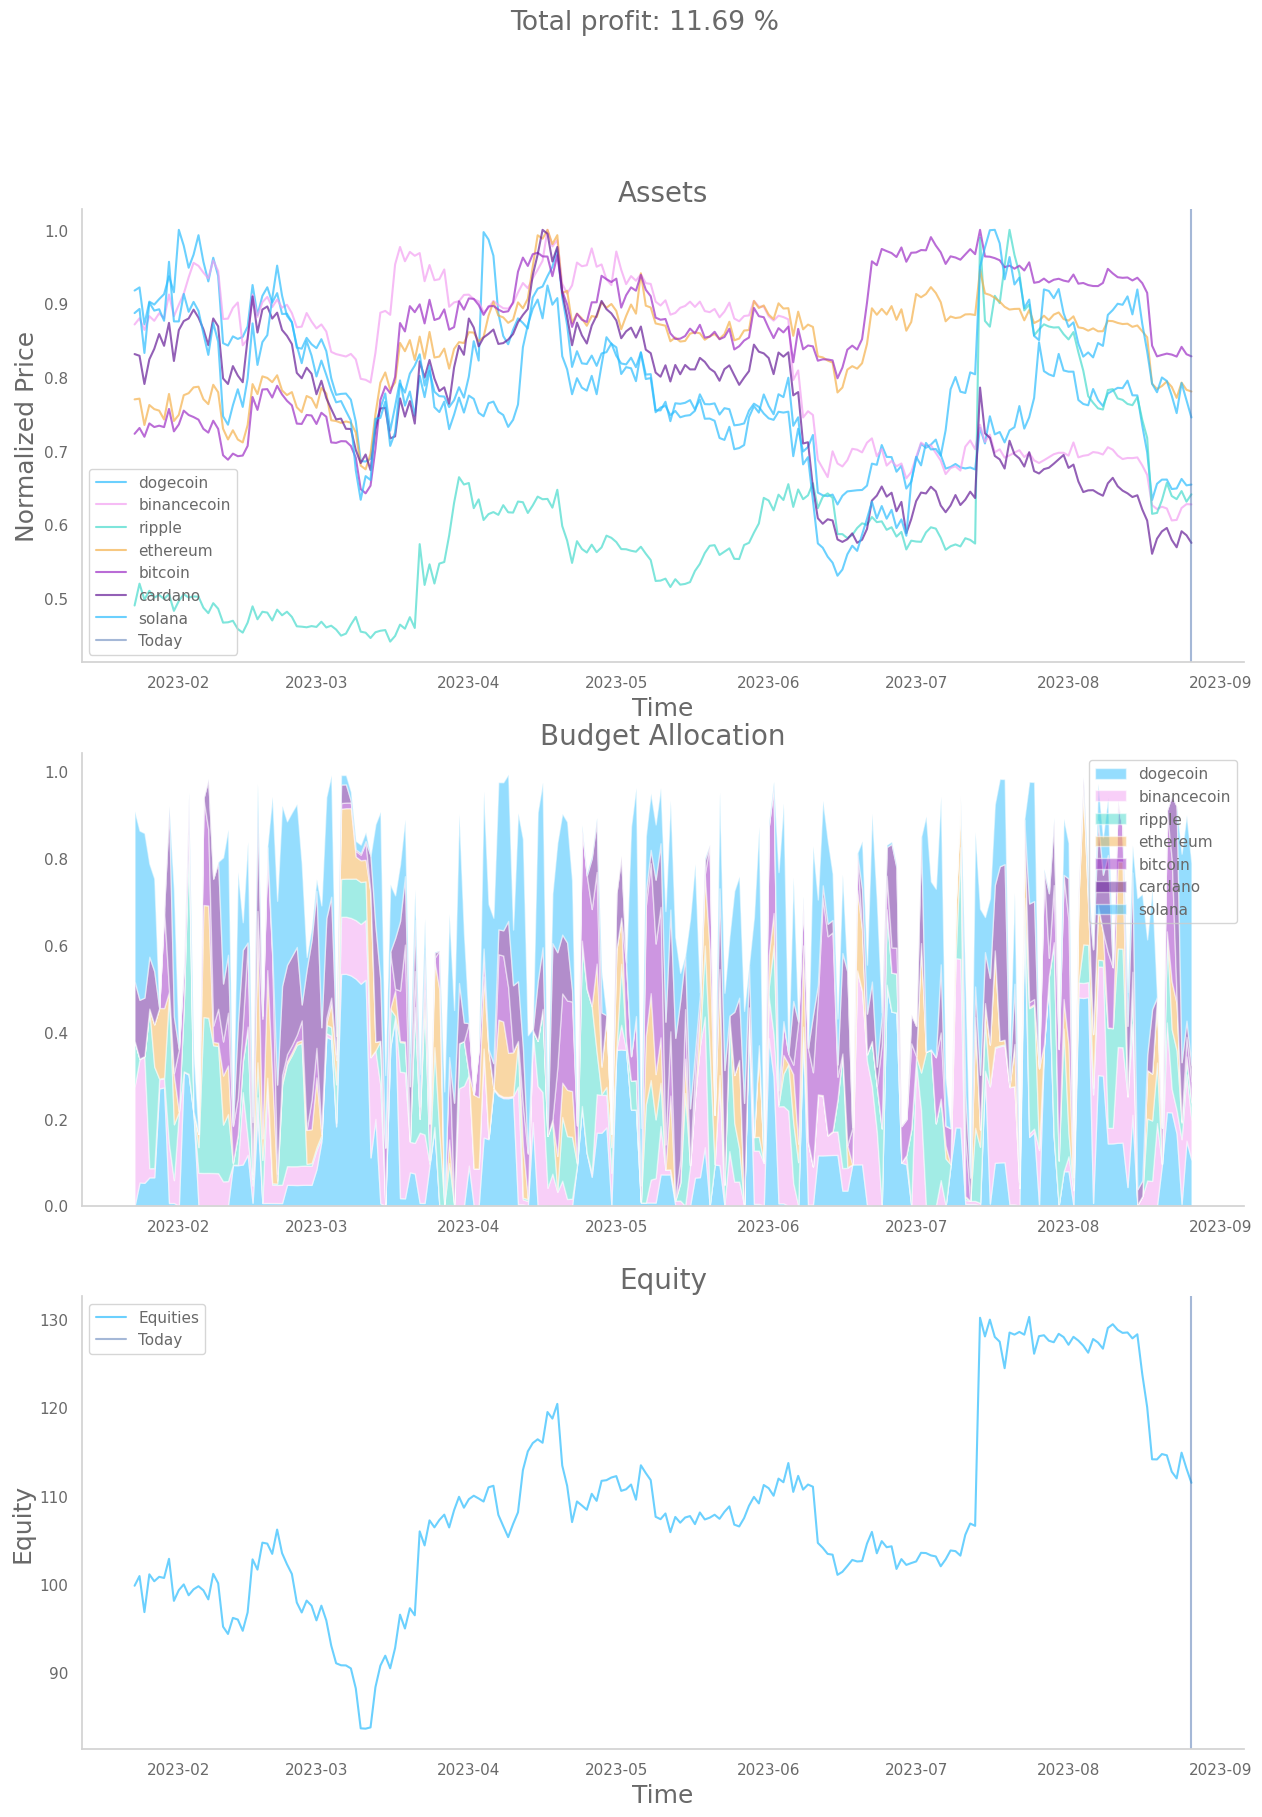

-1.4298448863326096

In [34]:
best_model = PPO.load('./models/best_model.zip')

simulate(SB3Agent(best_model), test_env, render=True)

In [35]:
# best_model = PPO.load('./models/best_model.zip')

# evaluate(best_model, test_vec_env)
# test_vec_env.envs[0].render()